# Replicating [Simple Black-box Adversarial Attacks](https://arxiv.org/pdf/1905.07121.pdf)

This notebook uses the replicate of the Simple Black-box Adversarial attack proposed by Guo et al. [More explanation]

In [1]:
# necessary imports

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from mat4py import loadmat
from torchvision import transforms

from imagenet import ImageNetDataSet

Folder of the ImageNet ILSVRC2012 validation dataset, its labels in the meta data. Note: After accessing [login-access to the ImagNet website](https://image-net.org/signup.php), go to the [ImageNet 2012 version](https://image-net.org/challenges/LSVRC/2012/2012-downloads.php) and download
* Development kit (Task 1 & 2). 2.5MB. - containing the labels and the meta data
* Validation images (all tasks). 6.3GB. - the validation images

Extract both and assign the locations of the folder and files to the corresponding Constants:

In [2]:
IMAGE_FOLDER = "../../../data/val"
LABEL_FILE = "../../../data/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"
META_FILE = "../../../data/ILSVRC2012_devkit_t12/data/meta.mat"

Let's load the meta data (mapping image id to label). The labels are not consitent: the indices from the official website do not match the indices from the PyTorch, pre-trained ResNet. So let's get them combined into one meta dataframe. The resnet image class data conversion ("imagenet_class_index.json") was taken from [here](https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json).

In [3]:
meta = pd.DataFrame.from_dict(loadmat(META_FILE)["synsets"])
meta.set_index("WNID", inplace=True)
with open("imagenet_class_index.json", "r") as file:
    pytorch_label_indices = json.load(file)

for key, (wnid, label) in pytorch_label_indices.items():
    meta.loc[wnid, "key"] = key
    meta.loc[wnid, "label"] = label.replace("_", " ")
meta.set_index("key", inplace=True)

Let's get the data.

In [4]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageNetDataSet(image_root=IMAGE_FOLDER, label_file=LABEL_FILE, transform=preprocess)

And let's see if everything worked out as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


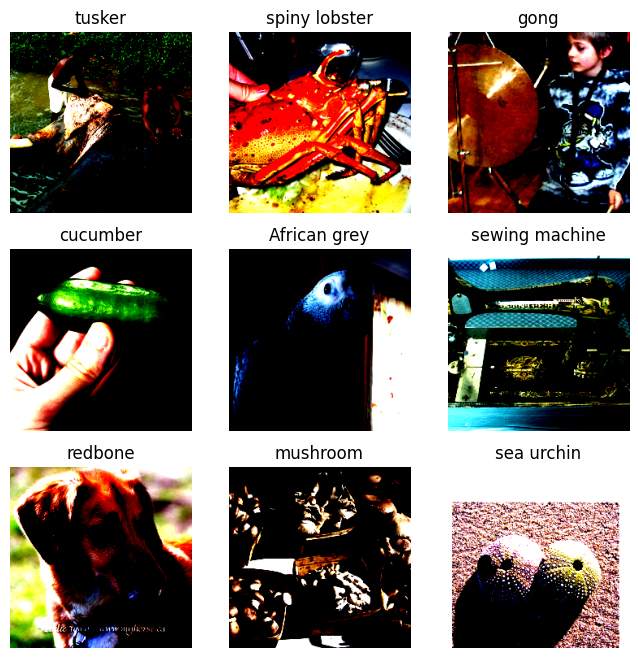

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(meta.loc[meta["ILSVRC2012_ID"] == int(label), "label"].iloc[0])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

## Classifying with pre-trained ResNet50

In [7]:
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True)
model.eval()

for _ in range(5):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probs, predictions = torch.topk(probabilities, 3)
    predictions = [meta.loc[f"{int(pred)}", "ILSVRC2012_ID"] for pred in predictions]
    print(f"The actual label is {int(label)}")
    print(f"the model thinks it is {predictions} with probability {probs}")

Using cache found in /home/eko/.cache/torch/hub/pytorch_vision_v0.10.0
/home/eko/.cache/pypoetry/virtualenvs/replicating-simple-blackbox-attack-tJdzEUmr-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eko/.cache/pypoetry/virtualenvs/replicating-simple-blackbox-attack-tJdzEUmr-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The actual label is 450
the model thinks it is [450, 496, 409] with probability tensor([9.9802e-01, 7.3045e-04, 2.1917e-04])
The actual label is 146
the model thinks it is [64, 32, 176] with probability tensor([0.2951, 0.1159, 0.0752])
The actual label is 512
the model thinks it is [512, 515, 593] with probability tensor([0.9880, 0.0056, 0.0026])
The actual label is 662
the model thinks it is [662, 671, 771] with probability tensor([0.3614, 0.2343, 0.1727])
The actual label is 320
the model thinks it is [968, 992, 970] with probability tensor([0.2316, 0.1308, 0.1237])
